In [73]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [49]:
# Load datasets
early_stage = loadmat('Data/CWRU/early_stage_fault.mat')['X278_DE_time'].squeeze()
mid_stage = loadmat('Data/CWRU/mid_stage_fault.mat')['X274_DE_time'].squeeze()
late_stage = loadmat('Data/CWRU/late_stage_fault.mat')['X270_DE_time'].squeeze()

print(early_stage.shape, mid_stage.shape, late_stage.shape)

(121535,) (121351,) (121168,)


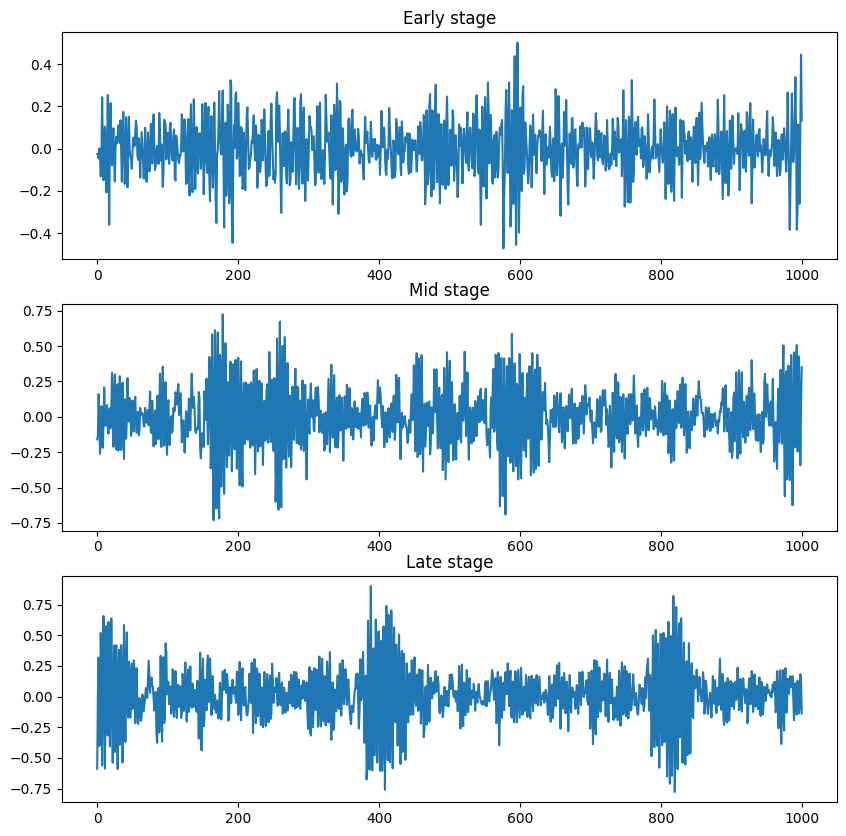

In [57]:
# subplot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(early_stage[:1000])
axs[0].set_title('Early stage')
axs[1].plot(mid_stage[:1000])
axs[1].set_title('Mid stage')
axs[2].plot(late_stage[:1000])
axs[2].set_title('Late stage')
plt.show()




In [58]:
# normalize data
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

early_stage_normalized = normalize(early_stage)
mid_stage_normalized = normalize(mid_stage)
late_stage_normalized = normalize(late_stage)


### Divide each dataset into fixed-size overlapping segments.

In [59]:
def segment_signal(data, window_size=1024, overlap=512):
    segments = []
    for start in range(0, len(data) - window_size + 1, window_size - overlap):
        segments.append(data[start:start + window_size])
    return np.array(segments)

early_normalized_segments = segment_signal(early_stage_normalized)
mid_normalized_segments = segment_signal(mid_stage_normalized)
late_normalized_segments = segment_signal(late_stage_normalized)

print(f"Early segments: {early_normalized_segments.shape}")
print(f"Mid segments: {mid_normalized_segments.shape}")
print(f"Late segments: {late_normalized_segments.shape}")


Early segments: (236, 1024)
Mid segments: (236, 1024)
Late segments: (235, 1024)


### Create Synthetic Labels for Fault Progression
$1: Early-stage fault. \\
2: Mid-stage fault. \\
3: Late-stage fault.$

In [78]:
early_labels = np.ones(len(early_normalized_segments))  # Label 1 for early-stage
mid_labels = np.full(len(mid_normalized_segments), 2)   # Label 2 for mid-stage
late_labels = np.full(len(late_normalized_segments), 3) # Label 3 for late-stage

# Combine all segments and labels
all_segments = np.vstack((early_normalized_segments, mid_normalized_segments, late_normalized_segments))
all_labels = np.hstack((early_labels, mid_labels, late_labels))


### Train-Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(all_segments, all_labels, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (565, 1024), (565,)
Testing set: (142, 1024), (142,)


In [63]:
early_train_data = early_normalized_segments.reshape(len(early_normalized_segments), -1)


### Train an Autoencoder 

2024-12-27 17:01:59.443269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2000
6/6 [==============================] - 1s 29ms/step - loss: 0.9969 - val_loss: 1.0265
Epoch 2/2000
6/6 [==============================] - 0s 14ms/step - loss: 0.9900 - val_loss: 1.0253
Epoch 3/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9852 - val_loss: 1.0237
Epoch 4/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9772 - val_loss: 1.0210
Epoch 5/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9624 - val_loss: 1.0157
Epoch 6/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9413 - val_loss: 1.0059
Epoch 7/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9133 - val_loss: 0.9912
Epoch 8/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8827 - val_loss: 0.9754
Epoch 9/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8565 - val_loss: 0.9631
Epoch 10/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.8297 - val_loss: 0.9562
Epoch 11/2000
6/6

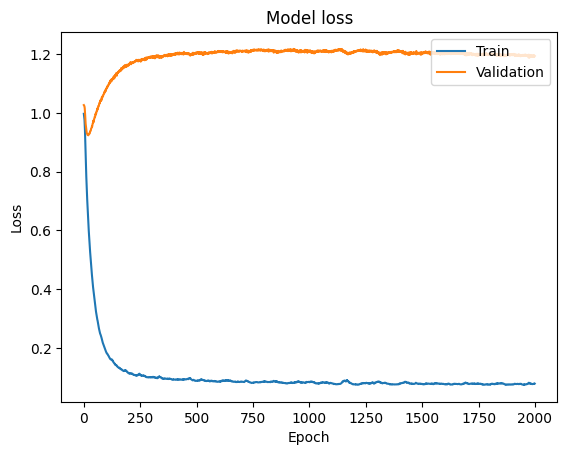

In [97]:

input_dim = early_train_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(early_train_data, early_train_data, epochs=2000, batch_size=32, validation_split=0.2)

# plot loss
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [87]:
from sklearn.ensemble import RandomForestClassifier

# Flatten segments for classifier input
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_flat, y_train)

# Evaluate
accuracy = classifier.score(X_test_flat, y_test)
print(f"Classification Accuracy: {accuracy}")


Classification Accuracy: 0.6619718309859155


8/8 [==============================] - 0s 1ms/step


/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_1549/3825985693.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, label=label, shade=True)
/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_1549/3825985693.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, label=label, shade=True)
/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_1549/3825985693.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, label=label, shade=True)


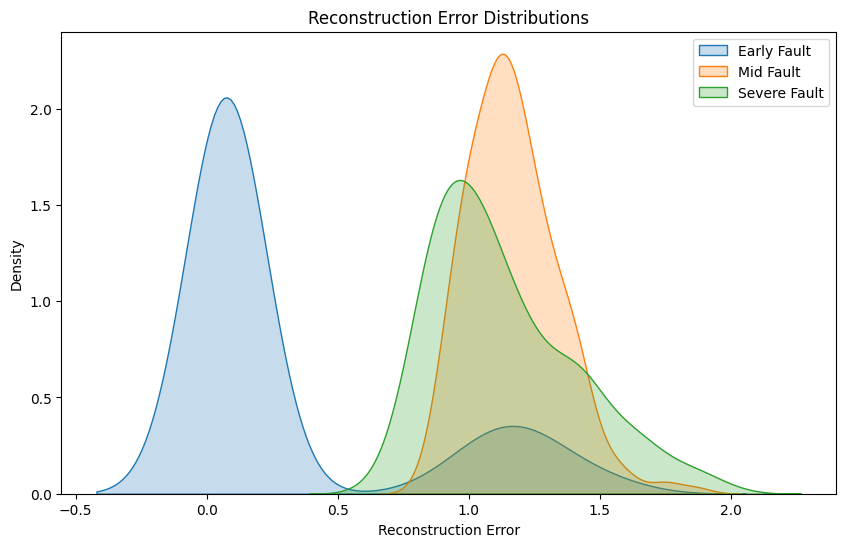

Threshold 1 (Early/Mid Fault): 0.7351279565538535
Threshold 2 (Mid/Severe Fault): 1.1509966114389907


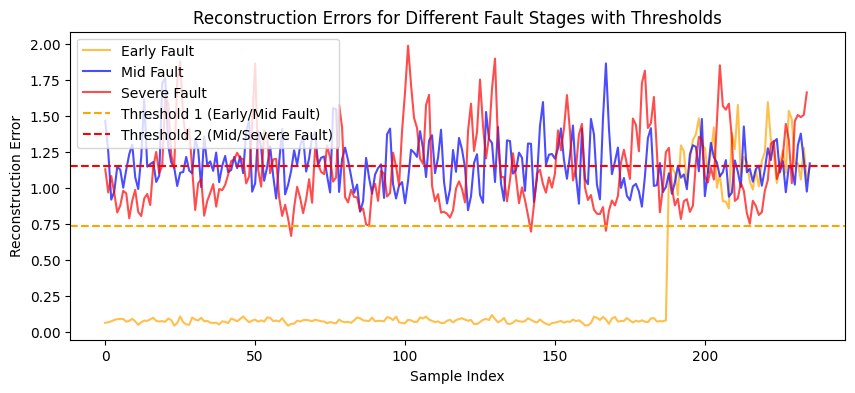

In [98]:
# Flatten all three datasets for processing
early_data_flat = early_normalized_segments.reshape(len(early_normalized_segments), -1)
mid_data_flat = mid_normalized_segments.reshape(len(mid_normalized_segments), -1)
late_data_flat = late_normalized_segments.reshape(len(late_normalized_segments), -1)

# Get reconstructions for each dataset
reconstruction_early = autoencoder.predict(early_data_flat)
reconstruction_mid = autoencoder.predict(mid_data_flat)
reconstruction_late = autoencoder.predict(late_data_flat)

# Calculate reconstruction errors for each dataset
reconstruction_error_early = np.mean((early_data_flat - reconstruction_early) ** 2, axis=1)
reconstruction_error_mid = np.mean((mid_data_flat - reconstruction_mid) ** 2, axis=1)
reconstruction_error_late = np.mean((late_data_flat - reconstruction_late) ** 2, axis=1)
# Combine all reconstruction errors into one dictionary for comparison
errors = {
    "Early Fault": reconstruction_error_early,
    "Mid Fault": reconstruction_error_mid,
    "Severe Fault": reconstruction_error_late
}

# Visualize reconstruction error distributions
import seaborn as sns
plt.figure(figsize=(10, 6))
for label, error in errors.items():
    sns.kdeplot(error, label=label, shade=True)
plt.title("Reconstruction Error Distributions")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.show()

# Define thresholds based on the mean reconstruction errors
threshold_1 = (np.mean(reconstruction_error_early) + np.mean(reconstruction_error_mid)) / 2
threshold_2 = (np.mean(reconstruction_error_mid) + np.mean(reconstruction_error_late)) / 2

print(f"Threshold 1 (Early/Mid Fault): {threshold_1}")
print(f"Threshold 2 (Mid/Severe Fault): {threshold_2}")

# Create a visualization showing errors with thresholds
plt.figure(figsize=(10, 4))
plt.plot(reconstruction_error_early, label='Early Fault', alpha=0.7, color='orange')
plt.plot(reconstruction_error_mid, label='Mid Fault', alpha=0.7, color='blue')
plt.plot(reconstruction_error_late, label='Severe Fault', alpha=0.7, color='red')
plt.axhline(y=threshold_1, color='orange', linestyle='--', label='Threshold 1 (Early/Mid Fault)')
plt.axhline(y=threshold_2, color='red', linestyle='--', label='Threshold 2 (Mid/Severe Fault)')
plt.title('Reconstruction Errors for Different Fault Stages with Thresholds')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()





In [96]:
from sklearn.metrics import classification_report

y_pred = classifier.predict(X_test_flat)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.84      0.62      0.71        58
         2.0       0.67      0.67      0.67        48
         3.0       0.51      0.72      0.60        36

    accuracy                           0.66       142
   macro avg       0.67      0.67      0.66       142
weighted avg       0.70      0.66      0.67       142

